In [64]:
import os
import sys
import io
import random
import json
import time
from collections import defaultdict, deque
import datetime
import math
import copy
from contextlib import redirect_stdout
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import torch
import torch.distributed as dist
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
import pycocotools.mask as mask_util
from pycocotools.cocoeval import COCOeval

In [65]:
dataset_base_path = '../data/clevr/CLEVR_CoGenT_v1.0/'
x_train = []
for img in os.listdir(dataset_base_path + 'images/trainA'):
    x_train.append(img)
x_val = []
for img in os.listdir(dataset_base_path + 'images/valA'):
    x_val.append(img)

print('Number of training images: ', len(x_train))
print('Number of validation images: ', len(x_val))

Number of training images:  70000
Number of validation images:  15000


In [66]:
DATA_PROPORTION = 0.01
x_train = x_train[:int(DATA_PROPORTION * len(x_train))]
x_val = x_val[:int(DATA_PROPORTION * len(x_val))]

print('Number of training images: ', len(x_train))
print('Number of validation images: ', len(x_val))
print(f'Sample training data: {x_train[0]}')

Number of training images:  700
Number of validation images:  150
Sample training data: CLEVR_trainA_029042.png


(320, 480, 4)


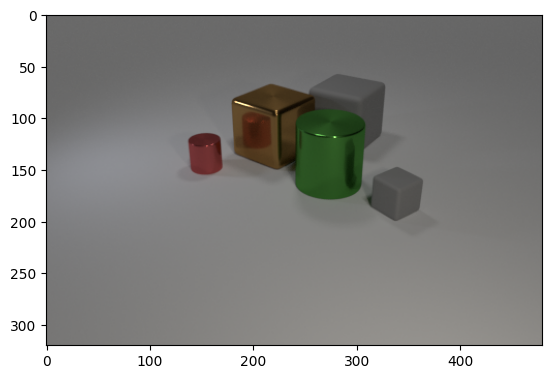

In [67]:
idx = random.randint(0, len(x_train))
img = plt.imread(dataset_base_path + 'images/trainA/' + x_train[idx])
INPUT_SHAPE = img.shape
print(INPUT_SHAPE)
plt.imshow(img)
plt.show()

In [68]:
y_train = json.load(open(dataset_base_path + "scenes/CLEVR_trainA_scenes.json", "r"))
y_val = json.load(open(dataset_base_path + "scenes/CLEVR_valA_scenes.json", "r"))
y_train = y_train['scenes']
y_val = y_val['scenes']
print('Number of training scenes: ', len(y_train))
print('Number of validation scenes: ', len(y_val))
print(f'Sample training data: {y_train[0]}')

Number of training scenes:  70000
Number of validation scenes:  15000
Sample training data: {'image_filename': 'CLEVR_trainA_000000.png', 'objects': [{'pixel_coords': [131, 173, 9.2485990524292], 'size': 'large', 'color': 'yellow', 'material': 'metal', 'shape': 'sphere', '3d_coords': [0.044448722153902054, -2.6995933055877686, 0.699999988079071], 'rotation': 303.2391460924107}, {'pixel_coords': [252, 114, 11.72614574432373], 'size': 'large', 'color': 'cyan', 'material': 'metal', 'shape': 'cylinder', '3d_coords': [-0.4431268870830536, 0.7946366667747498, 0.699999988079071], 'rotation': 155.1092991164171}, {'pixel_coords': [196, 115, 12.643919944763184], 'size': 'small', 'color': 'gray', 'material': 'rubber', 'shape': 'sphere', '3d_coords': [-1.9712634086608887, 0.4360339641571045, 0.3499999940395355], 'rotation': 300.13863658809737}], 'split': 'trainA', 'image_index': 0, 'relationships': {'behind': [[1, 2], [2], []], 'front': [[], [0], [0, 1]], 'left': [[], [0, 2], [0]], 'right': [[1, 2

In [69]:
# Filter y_train and y_val to x_train and x_val (relative paths)
y_train = [y for y in y_train if y['image_filename'] in x_train]
y_val = [y for y in y_val if y['image_filename'] in x_val]
print('Number of training scenes: ', len(y_train))
print('Number of validation scenes: ', len(y_val))
print(f'Sample training data: {y_train[0]}')

Number of training scenes:  700
Number of validation scenes:  150
Sample training data: {'image_filename': 'CLEVR_trainA_000030.png', 'objects': [{'pixel_coords': [277, 116, 11.548401832580566], 'size': 'large', 'color': 'red', 'material': 'metal', 'shape': 'cylinder', '3d_coords': [-0.07860971987247467, 1.0946065187454224, 0.699999988079071], 'rotation': 91.91998761696603}, {'pixel_coords': [307, 176, 9.962418556213379], 'size': 'small', 'color': 'yellow', 'material': 'rubber', 'shape': 'cube', '3d_coords': [1.7698845863342285, 0.20507781207561493, 0.3499999940395355], 'rotation': 19.425017406174142}, {'pixel_coords': [223, 188, 8.914209365844727], 'size': 'large', 'color': 'green', 'material': 'metal', 'shape': 'cylinder', '3d_coords': [1.5800716876983643, -1.6387121677398682, 0.699999988079071], 'rotation': 26.05840353664247}, {'pixel_coords': [340, 117, 12.350903511047363], 'size': 'small', 'color': 'yellow', 'material': 'rubber', 'shape': 'sphere', '3d_coords': [0.3243083953857422

In [70]:
print(y_train[0].keys())
print("----" * 4)
print("Image filename: ", y_train[0]['image_filename'])
print("Split: ", y_train[0]['split'])
print("Image index: ", y_train[0]['image_index'])
print("----" * 4)
print("Objects: ")
for k, v in y_train[0]['objects'][0].items():
    print("\t", k, v)
print("----" * 4)
print("Relationships: ")
for k, v in y_train[0]['relationships'].items():
    print("\t", k, v)
print("----" * 4)
print("Directions: ")
for k, v in y_train[0]['directions'].items():
    print("\t", k, v)

dict_keys(['image_filename', 'objects', 'split', 'image_index', 'relationships', 'directions'])
----------------
Image filename:  CLEVR_trainA_000030.png
Split:  trainA
Image index:  30
----------------
Objects: 
	 pixel_coords [277, 116, 11.548401832580566]
	 size large
	 color red
	 material metal
	 shape cylinder
	 3d_coords [-0.07860971987247467, 1.0946065187454224, 0.699999988079071]
	 rotation 91.91998761696603
----------------
Relationships: 
	 right [[1, 3, 6], [3, 6], [0, 1, 3, 6], [6], [0, 1, 2, 3, 5, 6], [0, 1, 2, 3, 6], []]
	 front [[1, 2, 5, 6], [2], [], [0, 1, 2, 5, 6], [0, 1, 2, 3, 5, 6], [1, 2, 6], [1, 2]]
	 left [[2, 4, 5], [0, 2, 4, 5], [4, 5], [0, 1, 2, 4, 5], [], [4], [0, 1, 2, 3, 4, 5]]
	 behind [[3, 4], [0, 3, 4, 5, 6], [0, 1, 3, 4, 5, 6], [4], [], [0, 3, 4], [0, 3, 4, 5]]
----------------
Directions: 
	 above [0.0, 0.0, 1.0]
	 right [0.6563112735748291, 0.7544902563095093, -0.0]
	 front [0.754490315914154, -0.6563112735748291, -0.0]
	 behind [-0.754490315914154, 

In [71]:
for k, v in y_train[0]['objects'][0].items():
    print("\t", k, v)

	 pixel_coords [277, 116, 11.548401832580566]
	 size large
	 color red
	 material metal
	 shape cylinder
	 3d_coords [-0.07860971987247467, 1.0946065187454224, 0.699999988079071]
	 rotation 91.91998761696603


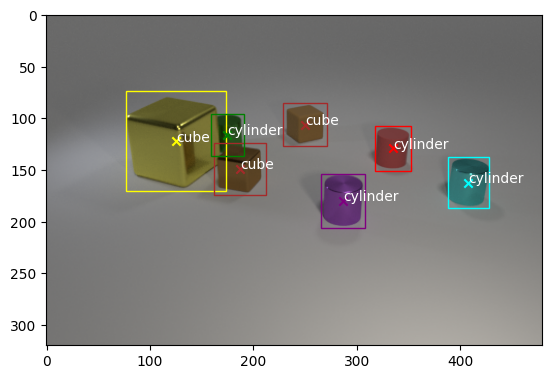

In [72]:
sample = random.randint(0, len(y_train))
img = plt.imread(dataset_base_path + 'images/trainA/' + y_train[sample]['image_filename'])
sizes = {
    "large": 0.7,
    "small": 0.35
}

for _obj in y_train[sample]['objects']:
    plt.scatter(_obj['pixel_coords'][0], _obj['pixel_coords'][1], marker='x', color=_obj['color'])
    plt.text(_obj['pixel_coords'][0], _obj['pixel_coords'][1], _obj['shape'], color='white')
    # plt.text(_obj['pixel_coords'][0], _obj['pixel_coords'][1], int(_obj['rotation']), color='white')
    # plt.gcf().gca().add_artist(plt.Rectangle((_obj['pixel_coords'][0] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750, _obj['pixel_coords'][1] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750), (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750 * 2, (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750 * 2, color=_obj['color'], fill=False))
    if _obj['shape'] == 'sphere':
        plt.gcf().gca().add_artist(
            plt.Rectangle(
            (_obj['pixel_coords'][0] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600, 
            _obj['pixel_coords'][1] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600), 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600 * 2, 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600 * 2, 
            color=_obj['color'], fill=False)
        )
    elif _obj['shape'] == 'cylinder':
        plt.gcf().gca().add_artist(plt.Rectangle(
            (_obj['pixel_coords'][0] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600, 
            _obj['pixel_coords'][1] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750), 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600 * 2, 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750 * 2, 
            color=_obj['color'], fill=False)
        )
    else:
        plt.gcf().gca().add_artist(plt.Rectangle(
            (_obj['pixel_coords'][0] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 800, 
            _obj['pixel_coords'][1] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 800), 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 800 * 2, 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 800 * 2, 
            color=_obj['color'], fill=False)
        )

plt.imshow(img)

In [73]:
# get bounding box
def get_bbox(obj):
    sizes = {
        "large": 0.7,
        "small": 0.35
    }
    bbox = []
    if obj['shape'] == 'sphere':
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2]
    elif obj['shape'] == 'cylinder':
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 750, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 750 * 2]
    else:
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 800, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 800, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 800 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 800 * 2]
    return bbox

In [74]:
# Extract data from a scene
def scene_extractor(scene):
    """
    Extracts the following information from a scene:
        - image_filename
        - objects
        - split
        - image_index
        - relationships
        - directions
    """
    # add bounding boxes to objects
    for obj in scene['objects']:
        obj['bbox'] = get_bbox(obj)
    return {
        'image_filename': scene['image_filename'],
        'objects': scene['objects'],
        'split': scene['split'],
        'image_index': scene['image_index'],
        'relationships': scene['relationships'],
        'directions': scene['directions']
    }

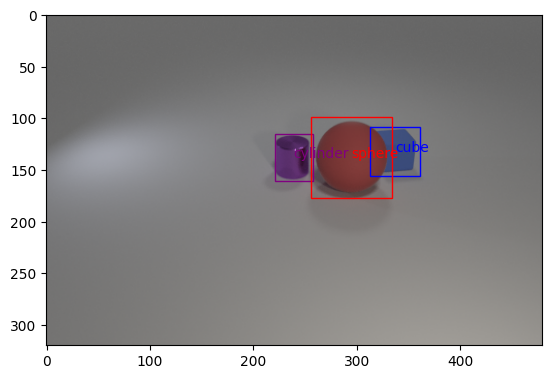

In [75]:
sample = random.randint(0, len(y_train))
scene = scene_extractor(y_train[sample])
# plot sample
img = plt.imread(dataset_base_path + 'images/trainA/' + scene['image_filename'])
# plot bounding boxes
for obj in scene['objects']:
    plt.gcf().gca().add_artist(plt.Rectangle(
        (obj['bbox'][0], obj['bbox'][1]), 
        obj['bbox'][2], 
        obj['bbox'][3], 
        color=obj['color'], fill=False)
    )
    # show labels
    plt.text(obj['pixel_coords'][0], obj['pixel_coords'][1], obj['shape'], color=obj['color'])
    
plt.imshow(img)

In [76]:
class CLEVRDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = y
        self.transforms = transforms
    
        self.x.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
        # sort y to match x
        self.y.sort(key=lambda y: y['image_index'])

        self.classes = ['cube', 'sphere', 'cylinder']

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = cv2.imread(dataset_base_path + 'images/trainA/' + self.x[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img, (self.w, self.h))
        img = img.astype(np.float32)
        img = img / 255.0

        scene = scene_extractor(self.y[idx])
        boxes = []
        labels = []
        for obj in scene['objects']:
            boxes.append(obj['bbox'])
            labels.append(self.classes.index(obj['shape']))

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # getting the areas of the boxes
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img,
                            bboxes = target['boxes'],
                            labels = labels)
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img, target

In [77]:
# plot bounding boxes
def plot_bbox(img, target):
    for i in range(len(target['boxes'])):
        plt.gcf().gca().add_artist(plt.Rectangle(
            (target['boxes'][i][0], target['boxes'][i][1]), 
            target['boxes'][i][2], 
            target['boxes'][i][3], 
            color='red', fill=False)
        )
        # show labels
        plt.text(target['boxes'][i][0], target['boxes'][i][1], test.classes[target['labels'][i]], color='red')
    plt.imshow(img)

(320, 480, 3)
{'boxes': tensor([[174.9544,  84.9430,  32.0913,  40.1141],
        [206.1235, 131.1235,  87.7530,  87.7530],
        [386.1542, 132.1542,  51.6917,  51.6917],
        [ 63.5666,  62.5666,  92.8667,  92.8667],
        [254.6621,  78.6621,  30.6757,  30.6757],
        [173.4221, 208.2776,  49.1558,  61.4448],
        [272.4592, 117.4592,  49.0816,  49.0816],
        [118.0502, 184.3128,  45.8996,  57.3745],
        [318.4682, 149.4682,  55.0636,  55.0636]]), 'labels': tensor([2, 1, 0, 0, 1, 2, 0, 2, 0]), 'area': tensor([ 6404.3916,  5133.7886, 26911.6855,   887.7950, 10748.2998, 18246.3770,
        15274.0049,  9158.6777, 24866.5801]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'image_id': tensor([451])}


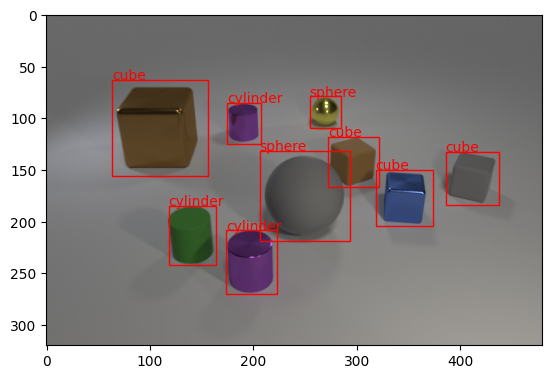

In [78]:
test = CLEVRDataset(x_train, y_train)
img, target = test[random.randint(0, len(y_train))]
print(img.shape)
print(target)
plot_bbox(img, target)

In [79]:
# +1 for background
num_classes = len(test.classes) + 1
num_classes

4

In [80]:
def get_object_detection_model(num_classes):
    # ~/.cache/torch/hub/checkpoints/resnet101-*.pth
    backbone = resnet_fpn_backbone(
        backbone_name="resnet101", 
        weights="ResNet101_Weights.DEFAULT",
        trainable_layers=3,    
    )
    faster_rcnn = FasterRCNN(backbone=backbone, num_classes=num_classes)
    # get number of input features for the classifier
    in_features = faster_rcnn.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    faster_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return faster_rcnn

In [81]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    

In [82]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [83]:
# use our dataset and defined transformations
dataset = CLEVRDataset(x_train, y_train, transforms= get_transform(train=True))
dataset_val = CLEVRDataset(x_val, y_val, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [84]:
# to train on gpu 1 if selected.
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [85]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    data_list = [None] * world_size
    dist.all_gather_object(data_list, data)
    return data_list

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            log_msg = self.delimiter.join(
                [
                    header,
                    "[{0" + space_fmt + "}/{1}]",
                    "eta: {eta}",
                    "{meters}",
                    "time: {time}",
                    "data: {data}",
                    "max mem: {memory:.0f}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "time: {time}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} Total time: {total_time_str} ({total_time / len(iterable):.4f} s / it)")


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {"images": [], "categories": [], "annotations": []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict["id"] = image_id
        img_dict["height"] = img.shape[-2]
        img_dict["width"] = img.shape[-1]
        dataset["images"].append(img_dict)
        bboxes = targets["boxes"].clone()
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets["labels"].tolist()
        areas = targets["area"].tolist()
        iscrowd = targets["iscrowd"].tolist()
        if "masks" in targets:
            masks = targets["masks"]
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if "keypoints" in targets:
            keypoints = targets["keypoints"]
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann["image_id"] = image_id
            ann["bbox"] = bboxes[i]
            ann["category_id"] = labels[i]
            categories.add(labels[i])
            ann["area"] = areas[i]
            ann["iscrowd"] = iscrowd[i]
            ann["id"] = ann_id
            if "masks" in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if "keypoints" in targets:
                ann["keypoints"] = keypoints[i]
                ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])
            dataset["annotations"].append(ann)
            ann_id += 1
    dataset["categories"] = [{"id": i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds

def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

def evaluate(imgs):
    with redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))

def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


class CocoEvaluator:
    def __init__(self, coco_gt, iou_types):
        if not isinstance(iou_types, (list, tuple)):
            raise TypeError(f"This constructor expects iou_types of type list or tuple, instead  got {type(iou_types)}")
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            with redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print(f"IoU metric: {iou_type}")
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        if iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        if iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        raise ValueError(f"Unknown iou type {iou_type}")

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "keypoints": keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results




In [86]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [87]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/torch/utils/data/dataset.py", line 295, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/tmp/ipykernel_1822356/2333654139.py", line 47, in __getitem__
    sample = self.transforms(image = img,
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/albumentations/core/composition.py", line 202, in __call__
    p.preprocess(data)
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/albumentations/core/utils.py", line 83, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/albumentations/core/utils.py", line 91, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 124, in convert_to_albumentations
    return convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=True)
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 390, in convert_bboxes_to_albumentations
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 390, in <listcomp>
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 334, in convert_bbox_to_albumentations
    check_bbox(bbox)
  File "/home/smbh/.venvs/gscmr4cqbir/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 420, in check_bbox
    raise ValueError(f"x_max is less than or equal to x_min for bbox {bbox}.")
ValueError: x_max is less than or equal to x_min for bbox (tensor(0.2930), tensor(0.1801), tensor(0.1891), tensor(0.2836), tensor(0)).
